In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="whitegrid", 
       rc={
           "figure.figsize": (21/2, 9/2),
           "figure.dpi": 100
       })
google = ["#4285F4", "#DB4437", "#F4B400", "#0F9D58"]
sns.set_palette(google)

seed_ = 20200218
np.random.seed(seed_)


import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, Activation, Conv1D, Lambda
from keras.optimizers import *

import tensorflow as tf
tf.random.set_seed(seed_)

### preprocess function

### มันมีอีกแบบนึง
```python
ds = ds.map(lambda window: (window[:-output_size], window[output_size:]))
```
> (window[:-output_size], window[output_size:]) จะใช้เป็น output จนจบ

เหมือนเป็นการ shift ข้อมูล

`[1, 2, 3, 4, 5] [6]`

`[1, 2, 3, 4, 5], [2, 3, 4, 5, 6]`

In [2]:
def windowing_arr(series, window_size, output_size=1, shuffle_buffer=1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    windows = ds.window(window_size + output_size, shift=1, drop_remainder=True)
    ds = windows.flat_map(lambda window: window.batch(window_size + output_size))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[:-output_size], window[-output_size:]))
    ds = np.array(list(ds.as_numpy_iterator()))
    x = np.array(ds[:, 0].tolist())
    y = np.array(ds[:, 1].tolist())
    return x, y

def windowing_arr2(series, window_size, output_size=1, shuffle_buffer=1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    windows = ds.window(window_size + output_size, shift=1, drop_remainder=True)
    ds = windows.flat_map(lambda window: window.batch(window_size + output_size))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[:-output_size], window[output_size:]))
    ds = np.array(list(ds.as_numpy_iterator()))
    x = np.array(ds[:, 0].tolist())
    y = np.array(ds[:, 1].tolist())
    return x, y

## Load Data

In [3]:
df = pd.read_csv("./data/sunspots.csv")

In [4]:
df.drop(columns=[df.columns[0]], axis=1, inplace=True)
df.rename(columns={df.columns[1]: 'monthly_sunspot'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,monthly_sunspot
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             3252 non-null   datetime64[ns]
 1   monthly_sunspot  3252 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 50.9 KB


### preprocess data

In [6]:
window_size = 32
output_size = 1
shuffle_buffer  = 1000
split_time = 2800

In [7]:
sunspot = df['monthly_sunspot']

train = sunspot[:split_time]
dev = sunspot[split_time:]

In [8]:
X_train, Y_train = windowing_arr2(train, window_size, output_size, shuffle_buffer)
X_dev, Y_dev = windowing_arr2(dev, window_size, output_size, shuffle_buffer)

In [9]:
X_train.shape, Y_train.shape

((2768, 32), (2768, 32))

In [10]:
X_dev.shape, Y_dev.shape

((420, 32), (420, 32))

In [11]:
X_train = np.expand_dims(X_train, axis=-1)
X_dev = np.expand_dims(X_dev, axis=-1)

Y_train = np.expand_dims(Y_train, axis=-1)
Y_dev = np.expand_dims(Y_dev, axis=-1)

In [12]:
X_train.shape, X_dev.shape

((2768, 32, 1), (420, 32, 1))

In [13]:
Y_train.shape, Y_dev.shape

((2768, 32, 1), (420, 32, 1))

> (sample size, time step, channel)

## Model

#### Conv 1d Layer

```python
Conv1D(num_filter, ...)
```
num filter แสดงถึงจำนวน channel หลังจากทำ conv

##### padding
One of "valid", `"causal"` or `"same"` (case-insensitive). `"causal"` results in causal (dilated) convolutions, e.g. `output[t]` does not depend on `input[t+1:]`. Useful when modeling temporal data where the model should not violate the temporal order.

##### input shape
`(time step, num channel)`

In [14]:
model = Sequential()

# conv1d layer
# num output channel (num filter)
conv_layer = Conv1D(24, kernel_size=5, 
                    strides=1, padding="causal",
                   activation="relu", input_shape=[None, 1])

model.add(conv_layer)
model.add(LSTM(window_size, return_sequences=True))
model.add(LSTM(window_size//2, return_sequences=True))
model.add(Dense(4, activation="relu"))
model.add(Dense(1))

In [15]:
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="mean_absolute_error")

In [16]:
num_epochs = 100
batch_size = 16

hist = model.fit(X_train, Y_train, 
                 epochs=num_epochs, batch_size=batch_size, 
                 validation_data=(X_dev, Y_dev), verbose=2)

Epoch 1/100
173/173 - 2s - loss: 77.4374 - val_loss: 68.9300
Epoch 2/100
173/173 - 1s - loss: 68.1363 - val_loss: 59.4240
Epoch 3/100
173/173 - 1s - loss: 57.6394 - val_loss: 49.1373
Epoch 4/100
173/173 - 1s - loss: 46.4147 - val_loss: 39.1030
Epoch 5/100
173/173 - 1s - loss: 37.0505 - val_loss: 31.9316
Epoch 6/100
173/173 - 1s - loss: 30.7027 - val_loss: 27.0556
Epoch 7/100
173/173 - 1s - loss: 26.5890 - val_loss: 23.9635
Epoch 8/100
173/173 - 1s - loss: 23.6196 - val_loss: 21.6186
Epoch 9/100
173/173 - 1s - loss: 21.4165 - val_loss: 19.4616
Epoch 10/100
173/173 - 1s - loss: 19.6616 - val_loss: 18.4549
Epoch 11/100
173/173 - 1s - loss: 18.3708 - val_loss: 17.7817
Epoch 12/100
173/173 - 1s - loss: 17.4858 - val_loss: 17.5651
Epoch 13/100
173/173 - 1s - loss: 16.8378 - val_loss: 17.3104
Epoch 14/100
173/173 - 1s - loss: 16.3334 - val_loss: 17.3113
Epoch 15/100
173/173 - 1s - loss: 15.9272 - val_loss: 17.2990
Epoch 16/100
173/173 - 1s - loss: 15.6292 - val_loss: 17.4217
Epoch 17/100
173/

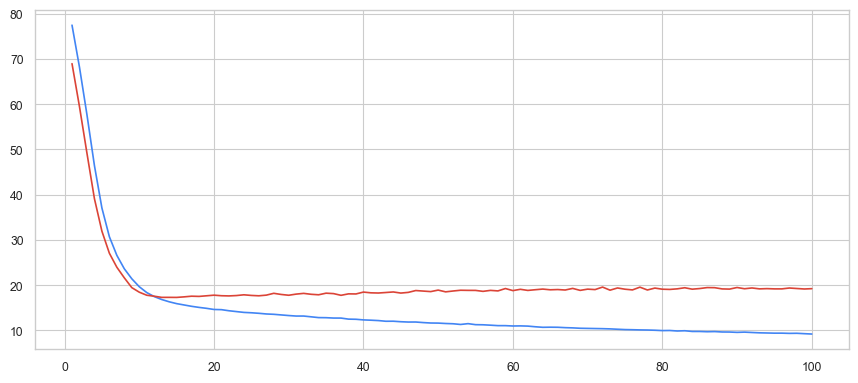

In [17]:
x_epochs = np.arange(1, num_epochs+1)
sns.lineplot(x_epochs, hist.history['loss'])
sns.lineplot(x_epochs, hist.history['val_loss'])

In [18]:
select_ind = 0
predicted = model.predict(X_dev)[select_ind]

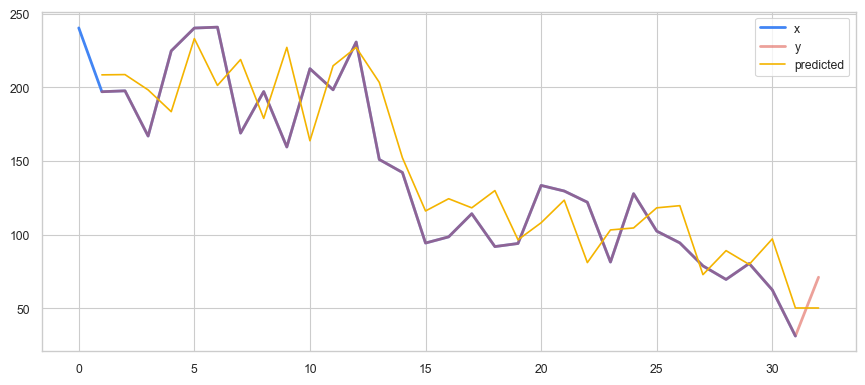

In [19]:
time_x = np.arange(len(predicted))
shift_time_x = time_x + 1

sns.lineplot(time_x, X_dev[select_ind].squeeze(), label='x', lw=2)
sns.lineplot(shift_time_x, Y_dev[select_ind].squeeze(), label='y', lw=2, alpha=0.5)
sns.lineplot(shift_time_x, predicted.squeeze(), label="predicted")